In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yfin
yfin.pdr_override()
import StockPull
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM

#load data
company = 'tsla'
start = dt.datetime(2012,1,1)
end = dt.datetime(2022,1,1)

data = StockPull.analysisout(company)

#prepare data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Price'].values.reshape(-1,1), data['Volume'].values.reshape((-1,1)))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [27]:
print(data)

           Date       Price     Volume
0    2017-11-27   21.120667   68338500
1    2017-11-28   21.170000   74242500
2    2017-11-29   20.502666  131511000
3    2017-11-30   20.590000   65274000
4    2017-12-01   20.435333   64393500
...         ...         ...        ...
1254 2022-11-18  180.190002   75904900
1255 2022-11-21  167.869995   92882700
1256 2022-11-22  169.910004   78452300
1257 2022-11-23  183.199997  109536700
1258 2022-11-25  182.860001   50672700

[1259 rows x 3 columns]


In [13]:

#build the model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1)) #prediction of the next closing value)

model.compile(optimizer ='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)



Epoch 1/25
38/38 [==============================] - 4s 27ms/step - loss: 0.0249
Epoch 2/25
38/38 [==============================] - 1s 26ms/step - loss: 0.0034
Epoch 3/25
38/38 [==============================] - 1s 26ms/step - loss: 0.0028
Epoch 4/25
38/38 [==============================] - 1s 26ms/step - loss: 0.0029
Epoch 5/25
38/38 [==============================] - 1s 27ms/step - loss: 0.0025
Epoch 6/25
38/38 [==============================] - 1s 26ms/step - loss: 0.0023
Epoch 7/25
38/38 [==============================] - 1s 27ms/step - loss: 0.0021
Epoch 8/25
38/38 [==============================] - 1s 26ms/step - loss: 0.0026
Epoch 9/25
38/38 [==============================] - 1s 26ms/step - loss: 0.0021
Epoch 10/25
38/38 [==============================] - 1s 26ms/step - loss: 0.0020
Epoch 11/25
38/38 [==============================] - 1s 26ms/step - loss: 0.0019
Epoch 12/25
38/38 [==============================] - 1s 26ms/step - loss: 0.0018
Epoch 13/25
38/38 [==================

In [14]:
#TEST THE MODEL ACCURACY

test_start = dt.datetime(2022,1,1)
test_end = dt.datetime.now()

test_data = StockPull.analysisout(company, '5y','1d')
actual_prices = test_data ['Price'].values

total_dataset = pd.concat((data['Price'], test_data['Price']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inpts = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inpts)


In [15]:
#makeprediction on test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


40/40 [==============================] - 1s 9ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


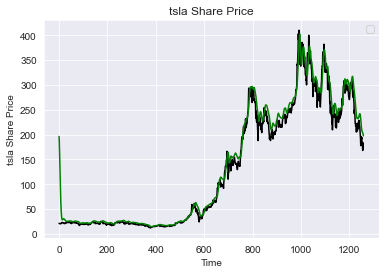

In [16]:
#plot the test predictions
plt.plot(actual_prices, color = "black")
plt.plot(predicted_prices, color = "green")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()


In [17]:
#Predict next day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction =  model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 [==============================] - 1s 732ms/step
Prediction: [[196.15309]]
